In [232]:
import math
import matplotlib.pyplot as plt
import numpy as np
from sympy import symbols, Eq, solve


# Homework 3

## Birth, death, and competition

Consider a modification to the birth-death process that we studied in class: Besides birth and death of individuals, let us introduce competition among individuals. This is meant to model the fact that resources are limited and cannot support a population when it grows too large. In that case, individuals have to compete for resources and may die if they lose the competition.

1. Recall that the birth and death processes can be described by the reactions:
\begin{align}
\mathbb{I} &\xrightarrow{\beta} 2 \mathbb{I} \\
\mathbb{I} &\xrightarrow{\delta} \mathbb{0}
\end{align}
Now add another reaction to represent competition. This reaction would describe the process by which "two individuals compete and one survives", i.e., "two individuals become one". Write down the reaction and denote the rate constant by $\chi$.

\begin{align}
2\mathbb{I} &\xrightarrow{\chi} \mathbb{I}
\end{align}


2. The overall rate of competition will depend on how often individuals run into each other, which in turn depends on the population size $N$. Since it takes two individuals to compete, the overall rate of competition will be proportional to $N^2$. This means that, within a short time $dt$, there will be $\chi N^2 dt$ events of competition on average, hence $\chi N^2 dt$ individuals will die from competition. At equilibrium, the total numbers of births and deaths should balance out. Derive the expected population size at equilibrium in terms of the rate constants $\beta$, $\delta$, and $\chi$.

(I don't know LaTeX, so sorry for this formatting!)

$$dN = N \beta \, dt - N \delta \, dt - N^2 \chi dt$$

$$\frac{dN}{dt} = (\beta - \delta) N - \chi N^2$$

Trying to use some funky differential equation stuff, but I never took diffie q so if I'm wrong then whoops

$$N = \frac{\beta-\delta}{\chi} $$


3. As before, we can rescale time so that $\delta = 1$ (i.e., average lifespan $= 1/\delta = 1$). Let us also use $\beta = 2$ as in our example in class. Now, if we look for $N_{eq} = 100$, what should $\chi$ be?

$$\chi$$ should be .01:
$$N = \frac{\beta-\delta}{\chi} = \frac{2-1}{\chi} = 100 $$


4. Now simulate the birth-death-competition process. You can either modify the `BirthDeath` class in [birth-death.ipynb](birth-death.ipynb), or copy the general `Gillespie` class from [gene-expression.ipynb](gene-expression.ipynb) and define a derived class by specifying appropriate stoichiometry matrices. Start from 1 individual and run the simulation for a sufficiently long time. Repeat several times and plot the trajectories of the population size versus time. Do you see extinctions? When the population does not go extinct, what happens? Describe the trends in your plots.


In [233]:
class LogGrowth:
    # modified from BirthDeath class

    """
    simulate the birth-death process using Gillespie algorithm.
    """

    def __init__(self, comp_rate, birth_rate, death_rate=1., N0=1):
        """
        initialize the population.
        inputs:
        comp_rate: float, competition interactions.
        birth_rate: float, birth rate per individual.
        death_rate: float, death rate per individual.
        N0: int, initial population size.
        """
        self.comp_rate = comp_rate
        self.birth_rate = birth_rate
        self.death_rate = death_rate
        self.pop_size = N0    # current population size
        self.time = 0.    # time since beginning of simulation
        self.pop_hist = [N0]    # list to record history of population size
        self.time_hist = [0.]    # list to record time of all events

    def next_event(self):
        """
        generate the waiting time and identity of the next event.
        outputs:
        tau: float, waiting time before next event.
        event: int, 0 means birth and 1 means death.
        """
        k_b = self.pop_size * self.birth_rate    # total birth rate
        k_d = self.pop_size * self.death_rate    # total death rate
        k_c = self.pop_size ** 2 * self.comp_rate # total competition interactions
        taus = np.random.exponential([1/k_b, 1/k_d])    # draw two random numbers from exponential dist
        tau_b, tau_d = taus[0], taus[1]
        tau_c = np.random.lognormal([1/k_c])
        np.append(taus, tau_c)
        if tau_c <= tau_b and tau_c <= tau_d:   # competition event first
            event = 1
            return tau_c, event
        elif tau_b <= tau_d and tau_b <= tau_c:    # birth happens first
            event = 0
            return tau_b, event
        elif tau_d <= tau_b and tau_d <= tau_c:    # death happens first
            event = 1
            return tau_d, event


    def run(self, T):
        """
        run simulation until time T since the beginning.
        inputs:
        T: float, time since the beginning of the simulation.
        """
        while self.time < T:
            if self.pop_size == 0:    # population goes extinct
                break    # exit while loop to end simulation
            tau, event = self.next_event()    # draw next event
            self.time += tau    # update time
            if event == 0:
                self.pop_size += 1    # birth
            elif event == 1:
                self.pop_size -= 1    # death
            self.time_hist.append(self.time)    # record time of event
            self.pop_hist.append(self.pop_size)    # record population size after event

In [234]:
beta = 2.    # growth rate
delta = 1.    # death rate

dt = 0.01    # time step size
T = 10.    # total time to solve the equation for

In [235]:
chi = .01
trials = 5    # number of simulations to repeat
bd_list = []

for i in range(trials):
    bd1 = LogGrowth(beta, delta, chi)
    bd1.run(T)
    print(f'current time = {bd1.time}, current population size = {bd1.pop_size}')
    bd_list.append(bd1)

current time = 0.4200712767462046, current population size = 0
current time = [10.00019858], current population size = 13270
current time = [10.00022995], current population size = 11432
current time = [10.00004228], current population size = 17496
current time = [0.30946358], current population size = 0


c:\users\cwslg\documents\pictures.2\school\programming\programming projects\projects\spring21\planning\venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


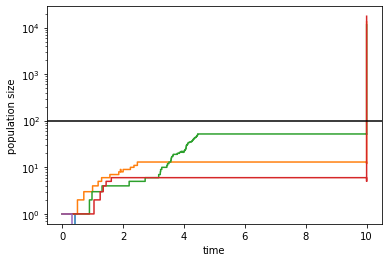

In [236]:
plt.figure()
for bd1 in bd_list:
    plt.plot(bd1.time_hist, bd1.pop_hist, drawstyle='steps-post')    # stochastic realizations
plt.axhline(y=100, color="black")
plt.yscale('log')
plt.xlabel('time')
plt.ylabel('population size')
plt.show()


5. For cases where the population does not go extinct, find the distribution of the population size at equilibrium. You can use the `collect_data()` function from [gene-expression.ipynb](gene-expression.ipynb) to collect the population size at selected time points. Calculate the mean, variance, and their ratio, as well as plot a histogram. Does your mean match the expected value $N_{eq}$? Is the distribution Poisson judging from the variance-to-mean ratio?

6. (optional) For this modified model, estimate the extinction probability starting from 1 individual. You have to run the simulation many times to collect the statistics (but each run does not have to be long). How does your result compare to the original birth-death process we studied in class? Try to give an intuitive explanation.